In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 22,
                     "savefig.dpi": 600,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer

FIGURES_DIR = './figures/shap/'
SAVE_FIG = False

In [2]:
import shap
import xgboost

In [3]:
# df_input = pd.read_pickle('./data/new_final/inputs.pkl')
# df_output = pd.read_pickle('./data/new_final/outputs.pkl')

In [4]:
df_input = pd.read_csv('./data/new_final/inputs.csv')
df_output = pd.read_csv('./data/new_final/outputs.csv')

In [5]:
df_input, df_output

(     OlAm_ind  CdAc_ind  OA_ind  Se_ind  OlAm  CdAc   OA     Se
 0           0         0       0       0   0.0   0.0  0.0  0.000
 1           0         0       0       1   0.0   0.0  0.0  0.025
 2           0         0       0       1   0.0   0.0  0.0  0.050
 3           0         0       0       1   0.0   0.0  0.0  0.075
 4           0         0       0       1   0.0   0.0  0.0  0.100
 ..        ...       ...     ...     ...   ...   ...  ...    ...
 620         1         1       1       0   0.5   0.1  0.5  0.000
 621         1         1       1       1   0.5   0.1  0.5  0.025
 622         1         1       1       1   0.5   0.1  0.5  0.050
 623         1         1       1       1   0.5   0.1  0.5  0.075
 624         1         1       1       1   0.5   0.1  0.5  0.100
 
 [625 rows x 8 columns],
      UV_ind  FL_ind  UV_PP     UV_PI       FL_PP        FL_PI  FL_SS
 0         0       0    NaN       NaN         NaN          NaN    NaN
 1         0       0    NaN       NaN         NaN    

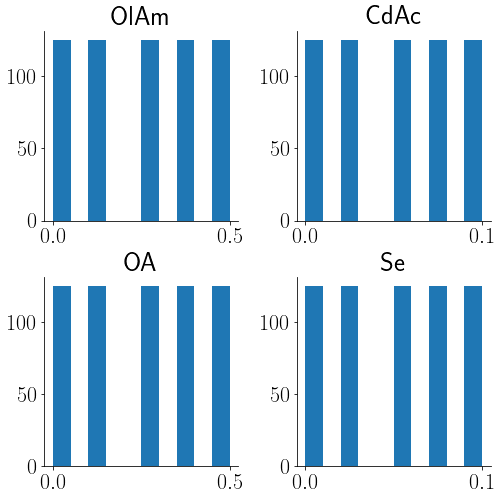

In [6]:
fig, axs = plt.subplots(2,2,figsize=(4*2, 4*2))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()
i = 0
for col in df_input:
    if not '_ind' in col:
        axs[i].hist(df_input[col])
        axs[i].set_title(col)
        i+=1
plt.show()

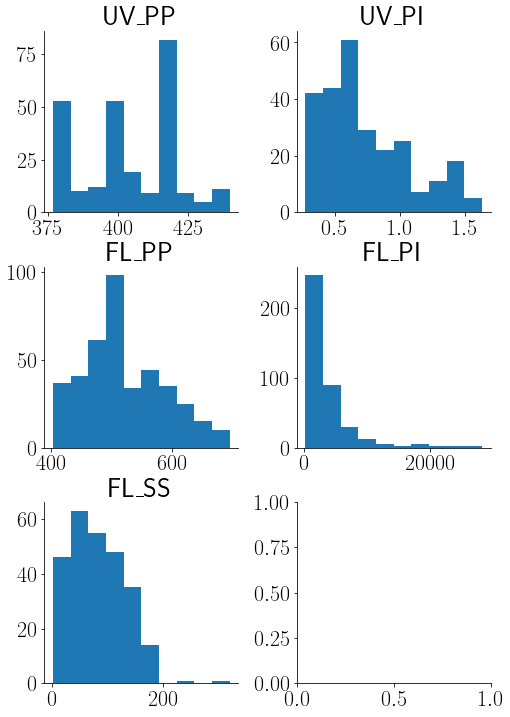

In [7]:
fig, axs = plt.subplots(3,2,figsize=(4*2, 4*3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()
i = 0
for col in df_output:
    if not '_ind' in col:
        axs[i].hist(df_output[col])
        axs[i].set_title(col)
        i+=1
plt.show()

## pre-processing functions

In [8]:
# process inputs
def transform_input(X_train, X_test):
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()

    for col in X_train.columns:
        qt = QuantileTransformer(random_state=0, n_quantiles=5)
        if '_ind' not in col:
            c_train = X_train[col].values
            c_test = X_test[col].values
            X_train_proc[col] = np.asarray(qt.fit_transform(c_train.reshape(-1,1)))
            X_test_proc[col] = np.asarray(qt.transform(c_test.reshape(-1,1)))
            
    return X_train_proc, X_test_proc

In [9]:
# process outputs
def transform_output(Y_train, Y_test):
    scaler = StandardScaler()
    impute = SimpleImputer(missing_values=np.nan, 
                         strategy="constant",
                         fill_value = 3.0
                      )
    Y_train_proc = scaler.fit_transform(Y_train.reshape(-1,1))
    Y_train_proc = impute.fit_transform(Y_train_proc)
    
    Y_test_proc = scaler.transform(Y_test.reshape(-1,1))
    Y_test_proc = impute.transform(Y_test_proc)
    
    return Y_train_proc, Y_test_proc

## Model Training functions

In [10]:
def xgb_train(X, y, task='cla'):
    """Train a xgboost model
    
    Parameters:
    -----------
        X : Input values as a pandas dataframe
        y : Output values as a numpy array
        
    Returns:
    --------
        model : Trained xgboost model
    """
    
    if task=='cla':
        obj = 'binary:logistic'
    elif task=='reg':
        obj = 'reg:squarederror'
    
    xgb_full = xgboost.DMatrix(X, label=y)

    # create a train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=7)
    
    X_train_proc, X_test_proc = transform_input(X_train, X_test)
    if task=='reg':
        Y_train_proc, Y_test_proc = transform_output(y_train, y_test)
    else:
        Y_train_proc = y_train
        Y_test_proc = y_test

    xgb_train = xgboost.DMatrix(X_train_proc, label=Y_train_proc)
    xgb_test = xgboost.DMatrix(X_test_proc, label=Y_test_proc)

    params = {
        "eta": 0.002,
        "max_depth": 3,
        "objective": obj,
        "subsample": 0.5
    }

    model_train = xgboost.train(params, xgb_train, 
                                20000, 
                                evals = [(xgb_test, "test")], 
                                verbose_eval=1000
                               )
    
    return model_train

In [11]:
def predict(model, data):
    dmat = xgboost.DMatrix(data)
    
    return model.predict(dmat)
    
def get_shap_plots(df, y, task='cla', show=True, name='None'):
    """Perform SHAP and obtain plots
    
    Parameters:
    -----------
        df   : Input values as a pandas dataframe
        y    : Output values as a numpy array
        task : string specifying the task
               cla - classification
               reg - regression
        show : to show plots rather than save
        name : file name to save the plot
              
        
    Returns:
    --------
        out : A dictonary with the following 
              model : Trained xgboost model
              explainer : Explainer model
    """
    model = xgb_train(df, y, task)
    predictor = lambda X : predict(model, X)
    explainer = shap.explainers.Exact(predictor, df)
    shap_values = explainer(df)
    #shap_values = shap_values[...,1]
    print(shap_values.shape)
    # plot local explanations
    shap.plots.beeswarm(shap_values, show=False)
    ax = plt.gca()
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('SHAP value', fontsize=22)
    if not show:
        plt.savefig(FIGURES_DIR+name+'_beeswarm.pdf')
        plt.close()
    else:
        plt.show()
    
    # plot the global importance
    shap.plots.bar(shap_values, show=False)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('mean SHAP value', fontsize=22)
    if not show:
        plt.savefig(FIGURES_DIR+name+'_bar.pdf')
        plt.close()
    else:
        plt.show()
    
    out = {}
    out['model'] = model
    out['explainer'] = shap_values

    return out

## Classification tasks

In [12]:
y = df_output['UV_ind'].values
df_X = df_input
out = get_shap_plots(df_X, y, task='cla', show=SAVE_FIG, name='uv_ind')

[0]	test-logloss:0.69209
[1000]	test-logloss:0.31140
[2000]	test-logloss:0.23239
[3000]	test-logloss:0.19910
[4000]	test-logloss:0.18012
[5000]	test-logloss:0.16784
[6000]	test-logloss:0.15912
[7000]	test-logloss:0.15351
[8000]	test-logloss:0.14838
[9000]	test-logloss:0.14570
[10000]	test-logloss:0.14280
[11000]	test-logloss:0.14081
[12000]	test-logloss:0.13943
[13000]	test-logloss:0.13814
[14000]	test-logloss:0.13748
[15000]	test-logloss:0.13694
[16000]	test-logloss:0.13625
[17000]	test-logloss:0.13564
[18000]	test-logloss:0.13555
[19000]	test-logloss:0.13562
[19999]	test-logloss:0.13482


Exact explainer: 626it [05:24,  1.87it/s]                                                                                              


(625, 8)


In [13]:
y = df_output['FL_ind'].values
df_X = df_input
out = get_shap_plots(df_X, y, task='cla', show=SAVE_FIG, name='fl_ind')

[0]	test-logloss:0.69126
[1000]	test-logloss:0.08315
[2000]	test-logloss:0.01972
[3000]	test-logloss:0.01361
[4000]	test-logloss:0.01268
[5000]	test-logloss:0.01238
[6000]	test-logloss:0.01230
[7000]	test-logloss:0.01231
[8000]	test-logloss:0.01234
[9000]	test-logloss:0.01238
[10000]	test-logloss:0.01241
[11000]	test-logloss:0.01244
[12000]	test-logloss:0.01247
[13000]	test-logloss:0.01248
[14000]	test-logloss:0.01249
[15000]	test-logloss:0.01251
[16000]	test-logloss:0.01250
[17000]	test-logloss:0.01251
[18000]	test-logloss:0.01251
[19000]	test-logloss:0.01253
[19999]	test-logloss:0.01254


Exact explainer: 626it [02:24,  4.05it/s]                                                                                              


(625, 8)


## Regression tasks

In [14]:
flags = df_output['UV_ind']==1
df_X = df_input[flags]
y = df_output[flags]['UV_PP'].values
out = get_shap_plots(df_X, y, task='reg', show=SAVE_FIG, name='uv_pp')

[0]	test-rmse:1.10048
[1000]	test-rmse:0.45032
[2000]	test-rmse:0.40488
[3000]	test-rmse:0.39764
[4000]	test-rmse:0.39514
[5000]	test-rmse:0.39499
[6000]	test-rmse:0.39678
[7000]	test-rmse:0.39818
[8000]	test-rmse:0.40071
[9000]	test-rmse:0.40408
[10000]	test-rmse:0.40637
[11000]	test-rmse:0.40918
[12000]	test-rmse:0.41111
[13000]	test-rmse:0.41269
[14000]	test-rmse:0.41551
[15000]	test-rmse:0.41850
[16000]	test-rmse:0.42180
[17000]	test-rmse:0.42360
[18000]	test-rmse:0.42516
[19000]	test-rmse:0.42814
[19999]	test-rmse:0.43014


Exact explainer: 264it [00:41,  4.78it/s]                                                                                              


(263, 8)


In [15]:
flags = df_output['FL_ind']==1
df_X = df_input[flags]
y = df_output[flags]['FL_PI'].values
out = get_shap_plots(df_X, y, task='reg', show=SAVE_FIG, name='fl_pi')

[0]	test-rmse:1.17212
[1000]	test-rmse:0.75032
[2000]	test-rmse:0.71274
[3000]	test-rmse:0.70260
[4000]	test-rmse:0.70429
[5000]	test-rmse:0.70845
[6000]	test-rmse:0.71282
[7000]	test-rmse:0.71862
[8000]	test-rmse:0.72585
[9000]	test-rmse:0.72849
[10000]	test-rmse:0.73359
[11000]	test-rmse:0.73961
[12000]	test-rmse:0.74375
[13000]	test-rmse:0.74792
[14000]	test-rmse:0.75364
[15000]	test-rmse:0.75725
[16000]	test-rmse:0.76321
[17000]	test-rmse:0.76715
[18000]	test-rmse:0.77275
[19000]	test-rmse:0.77707
[19999]	test-rmse:0.78140


Exact explainer: 401it [01:02,  5.40it/s]                                                                                              


(400, 8)


In [16]:
flags = df_output['FL_ind']==1
df_X = df_input[flags]
y = df_output[flags]['FL_PP'].values
out = get_shap_plots(df_X, y, task='reg', show=SAVE_FIG, name='fl_pp')

[0]	test-rmse:1.15430
[1000]	test-rmse:0.55752
[2000]	test-rmse:0.52718
[3000]	test-rmse:0.52564
[4000]	test-rmse:0.52761
[5000]	test-rmse:0.53043
[6000]	test-rmse:0.53446
[7000]	test-rmse:0.53866
[8000]	test-rmse:0.54221
[9000]	test-rmse:0.54681
[10000]	test-rmse:0.55181
[11000]	test-rmse:0.55634
[12000]	test-rmse:0.56024
[13000]	test-rmse:0.56313
[14000]	test-rmse:0.56661
[15000]	test-rmse:0.56977
[16000]	test-rmse:0.57256
[17000]	test-rmse:0.57599
[18000]	test-rmse:0.57811
[19000]	test-rmse:0.58048
[19999]	test-rmse:0.58269


Exact explainer: 401it [01:02,  5.40it/s]                                                                                              


(400, 8)
